## Softmax Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pca import PCA
import argparse
import network
import os, random, sys
from data import traffic_sign, generate_k_fold_set, onehot_encode, onehot_decode, z_score_normalize, append_bias
from model.softmax import SoftmaxRegression

In [2]:
### Q6(a) - Evaluate Network on all 43 traffic signs (aligned dataset)

# Load aligned data
X, y = traffic_sign(True)
X = X.astype(np.float32) # cast to float32 as float64 running out of memory
X = z_score_normalize(X) 

print(X.shape)
print(y.shape)
print(X.dtype)
print(y.dtype)

(34799, 1024)
(34799,)
float32
uint8


With PCA on unaligned
Current Fold: 0


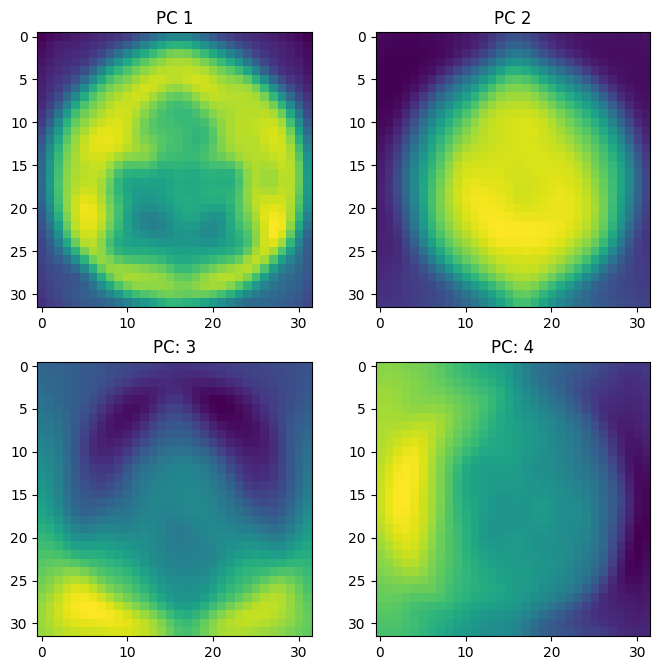

(27841, 300)


AttributeError: 'PCA' object has no attribute 'PCA_generate'

In [3]:
#%%
## 2. With PCA on unaligned

print("With PCA on unaligned")

# Load unaligned data
X, y = traffic_sign(False)
X = X.astype(np.float32) # cast to float32 as float64 running out of memory
X = z_score_normalize(X) 

DEBUG = False

# Softmax Regression Parameters
lr = 0.5
num_features = X.shape[1]
num_classes = y.max() + 1

train_loss_record = []

train_accuracy_record = []

holdout_loss_record = []

holdout_accuracy_record = []

test_accuracy_record = []

# PCA number of principal components
n_components = 300

first_plot = True

num_epochs = 300
epochs_print = [50, 100, 150, 200, 250, 300]

k = 10

total_test_accuracy = 0.0
total_test_loss = 0.0

cur_fold = 0
for train, valid, test in generate_k_fold_set((X, y), k):
    print(f"Current Fold: {cur_fold}")
    train_data, train_label = train
    valid_data, valid_label = valid
    test_data, test_label = test
    
    # Project data onto principal components
    pca = PCA(n_components)
    projected = pca.fit_transform(train_data) # len(train_data) x n_components
    
    # Plot principal components
    if first_plot == True : 
        pca.plot_PC()
        first_plot = False
    train_d = append_bias(projected)     
    valid_d = append_bias(pca.PCA_generate(valid_data))
    test_d = append_bias(pca.PCA_generate(test_data))

    softmax_model = SoftmaxRegression(lr, n_components, num_classes)
    best_w = softmax_model.W

    # Onehot encode labels
    y_true = onehot_encode(train_label)
    valid_label_onehot = onehot_encode(valid_label)
    test_label_onehot = onehot_encode(test_label)
    
    for epoch in range(num_epochs):
        y_hat = softmax_model.model(train_d)
        
        raw_train_loss = softmax_model.cross_entropy(y_true, y_hat)
        train_loss_norm = raw_train_loss / len(train_d) / num_classes # train loss normalized by # examples and classes
        
        train_loss_record.append(train_loss_norm)
        
        train_accuracy = softmax_model.accuracy(y_true, y_hat)
        train_accuracy_record.append(train_accuracy)
        
        holdout_y = softmax_model.model(valid_d)

        holdout_loss = softmax_model.cross_entropy(holdout_y, valid_label_onehot)
        holdout_loss_norm = holdout_loss / len(valid_d) / num_classes # holdout loss normalized by # examples and classes
        holdout_loss_record.append(holdout_loss_norm)

        holdout_accuracy = softmax_model.accuracy(holdout_y, valid_label_onehot)
        holdout_accuracy_record.append(holdout_accuracy)

        if holdout_accuracy >= max(holdout_accuracy_record[cur_fold * num_epochs:]):
            best_w = softmax_model.W

        # Update Weights
        softmax_model.update_weights(train_d, y_true, y_hat)

        if (epoch + 1) in epochs_print:
            print(f' epoch: {epoch + 1}, train accuracy: {train_accuracy:.4f}, train_loss_norm:{train_loss_norm:.4f}, '                f'valid_acc: {holdout_accuracy:.4f}, valid_loss_norm: {holdout_loss_norm:.4f}')

    # Run on Test Dataset
    test_y = softmax_model.model_w(test_d, best_w)

    test_accuracy = softmax_model.accuracy(test_y, test_label_onehot)

    print(f'Test accuracy: {test_accuracy:.4f}')

    test_accuracy_record.append(test_accuracy)

    raw_test_loss = softmax_model.cross_entropy(test_y, test_label_onehot)
    test_loss_norm = raw_test_loss / len(test_d) / num_classes
    total_test_loss += test_loss_norm
    print(f"Test loss norm: {test_loss_norm:.4f}")

    cur_fold += 1

print(f'Average test accuracy over {k} folds: {np.mean(test_accuracy_record):.4f} (+/- {np.std(test_accuracy_record):.4f})')
print(f'Average test loss per example and class over {k} folds: {total_test_loss / k}')


In [ ]:
def Confusion(pred, true):
    M=np.zeros((43,43))
    for p, t in zip(prediction, label):
        M[t][p] += 1
    return M

predictions = list(predictions)

M = Confusion(predictions, label)
M = M.astype(np.int64)
print("The accuracy on test data is {}.".format(accuracy))
sns.set()
plt.figure(figsize=(10,10))
f,ax=plt.subplots(figsize=(20,20))
sns.heatmap(M,annot=True,ax=ax)
ax.set_title('confusion matrix')
ax.set_xlabel('predict')
ax.set_ylabel('true')

In [ ]:
# (ii) Plot Batch vs. Stochastic Gradient Descent

fig, axs = plt.subplots(2, 1, constrained_layout=True)

epochs_error_bar = [50, 100, 150, 200, 250, 300] # 1-indexed
epochs_error_bar_0 = [epoch - 1 for epoch in epochs_error_bar] # 0-indexed

# Plot Loss
average_train_loss = average_out_data_k(train_loss_record)
train_loss_error_bar_y = [average_train_loss[epoch] for epoch in epochs_error_bar_0]
train_loss_error_bar_yerr = [np.std(get_data_at_epoch_fold(train_loss_record, epoch)) for epoch in epochs_error_bar_0]

axs[0].plot(average_train_loss, '-b', label='Stochastic')
axs[0].errorbar(x=epochs_error_bar_0, y=train_loss_error_bar_y, yerr=train_loss_error_bar_yerr, label='Stochastic error', fmt='-b')

axs[0].plot(batch_average_train_loss, '--r', label='Batch')
axs[0].errorbar(x=epochs_error_bar_0, y=batch_average_train_loss_error_bar_y, yerr=batch_average_train_loss_error_bar_yerr, label='Batch error', fmt='--r')

axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Normalized Loss')
axs[0].set_title('Batch vs. Stochastic Normalized Training Loss')

plt.savefig("plots/Q6b_ii.png")
plt.close(fig)


In [ ]:
### (c) Visualize the weights

from matplotlib.pyplot import figure

def weights2range(w, min=0, max=256):
    # Scales weights to be between min and max
    w /= np.max(w)
    w *= (max)
    w += min
    return w

# Plot image

weight_visualization_weights = best_w[:-1]

# Traffic sign classes to be plotted
ts_classes = [7, 11, 21, 25]

fig, axs = plt.subplots(4,1) 
fig.set_size_inches(10, 6)

for i, ts_class in enumerate(ts_classes):
    # Get weights for each class
    class_weights = weight_visualization_weights[:,ts_class].reshape((32, 32))
    # Scale to [0, 256]
    img_weights = weights2range(class_weights)
    # Plot image
    axs[i].set_title(f'Class {ts_class}')
    axs[i].imshow(img_weights)

plt.tight_layout()
plt.savefig('plots/Q6c_weights.png')
